In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = [7, 7]

# Dataset preparation

### Load MNIST

In [3]:
# Subtracts the pre-calculated mean of training set from train, validation and test set.
transform = T.Compose([T.ToTensor(), T.Normalize((0.13087,), (1,))])

# Dataset
mnist_train = dset.MNIST('../datasets', train=True, download=True, transform=transform)
mnist_test = dset.MNIST('../datasets', train=False, download=True, transform=transform)

### Seperate train, validation, and test set

In [4]:
# DataLoaders
num_train = 48000
loader_train = DataLoader(mnist_train, batch_size=64,
                          sampler=sampler.SubsetRandomSampler(range(num_train)))
loader_val = DataLoader(mnist_train, batch_size=64,
                        sampler=sampler.SubsetRandomSampler(range(num_train, 60000)))
loader_test = DataLoader(mnist_test, batch_size=64)

### Visualize a minibatch of data

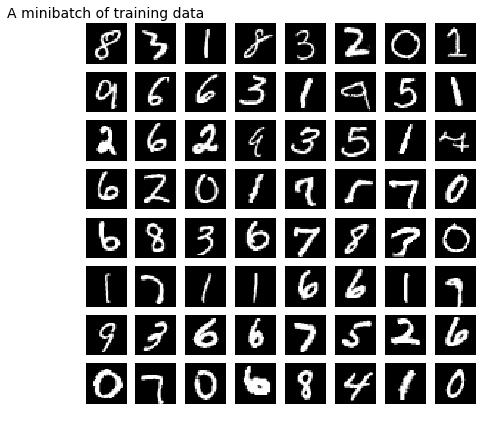

In [5]:
X, y = iter(loader_train).next()
data = X.numpy()

for i in range(8):
    for j in range(8):
        plt_idx = i * 8 + j + 1
        ax = plt.subplot(8, 8, plt_idx)
        plt.imshow(data[j+(i*8),0]+0.13087, cmap='gray', vmin=0, vmax=1)
        plt.axis('off')
        if i == 0 and j == 0:
            plt.title('A minibatch of training data', size=14)
plt.show()

### Visualize the different classes of data

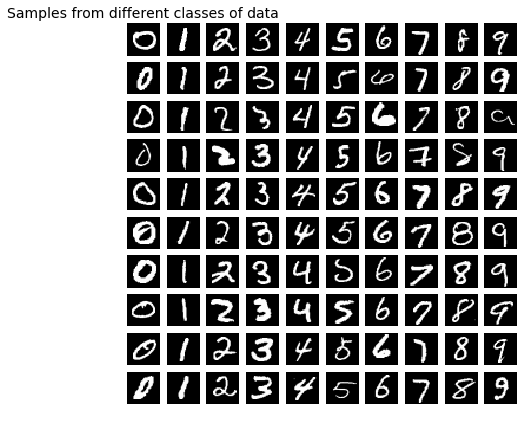

In [6]:
from utils.visualization_utils import pltClasses

categorized_data = {0:[],1:[], 2:[],3:[],4:[],5:[],6:[],7:[],8:[],9:[]}
for X, y in loader_train:
    data = X.numpy()
    label = y.numpy().astype(int)
    for num, category in enumerate(label):
        categorized_data[category].append([data[num]])
    category_lens = np.array([len(samples) for category,samples in categorized_data.items()])
    if np.min(category_lens)>10:
        break

pltClasses(categorized_data,'Samples from different classes of data')

# Training the Model

### Select device

In [7]:
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print('Using device=GPU') if use_cuda else print('Using device=CPU')

Using device=GPU


### Create Model

In [8]:
from classifiers.cnn import ConvNet
model = ConvNet()

### Optimal Hyperparameter Search

Optimal hyperparameters found: learning_rate = 0.2, weight_decay = 0.002.

In [9]:
# from utils.training_utils import train_model
# print('~~~ Training with GPU ~~~\n') if use_cuda else print('~~~ Training with CPU ~~~\n')

# # Experiment Settings
# print_every = 200

# # Hyperparameters
# momentum = 0
# num_epochs = 1

# for i in range(100):
#     learning_rate = 10**np.random.uniform(-1.5,-0.5)
#     weight_decay = 10**np.random.uniform(-4,-2)
#     print('lr: %.4f, reg: %.4f\n' % (learning_rate, weight_decay))
#     model = ConvNet()
#     optimizer = optim.SGD(model.parameters(), lr=learning_rate,
#                           momentum=momentum, weight_decay=weight_decay)
#     train_history = train_model(model, optimizer, loader_train,
#                                 loader_val, num_epochs,
#                                 print_every, device)

### Start Training

In [10]:
# Hyperparameters
learning_rate = 0.2
momentum = 0
weight_decay = 0.002
num_epochs = 10

In [11]:
from utils.training_utils import train_model
print('~~~ Training with GPU ~~~') if use_cuda else print('~~~ Training with CPU ~~~\n')
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Model has %.2fK trainable parameters.\n' % (num_params/1000))

optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                      momentum=momentum, weight_decay=weight_decay)
train_history = train_model(model, optimizer, loader_train,
                            loader_val, num_epochs,
                            device)

~~~ Training with GPU ~~~
Model has 661.13K trainable parameters.

Epoch 1:
Training data: loss = 0.4083, accuracy = 86.48
Validation data: loss = 0.1886, accuracy = 94.17
-----------
Epoch 2:
Training data: loss = 0.0688, accuracy = 97.88
Validation data: loss = 0.0605, accuracy = 98.02
-----------
Epoch 3:
Training data: loss = 0.0525, accuracy = 98.37
Validation data: loss = 0.0505, accuracy = 98.48
-----------
Epoch 4:
Training data: loss = 0.0455, accuracy = 98.56
Validation data: loss = 0.0557, accuracy = 98.28
-----------
Epoch 5:
Training data: loss = 0.0431, accuracy = 98.64
Validation data: loss = 0.0400, accuracy = 98.81
-----------
Epoch 6:
Training data: loss = 0.0398, accuracy = 98.72
Validation data: loss = 0.0444, accuracy = 98.72
-----------
Epoch 7:
Training data: loss = 0.0387, accuracy = 98.82
Validation data: loss = 0.0466, accuracy = 98.65
-----------
Epoch 8:
Training data: loss = 0.0381, accuracy = 98.79
Validation data: loss = 0.0450, accuracy = 98.64
---------

# Evaluating the model

### 1. Inference Accuracy

In [12]:
from utils.training_utils import evaluation
train_acc, _ = evaluation(model, loader_train, None, device)
val_acc, _ = evaluation(model, loader_val, None, device)
test_acc, _ = evaluation(model, loader_test, None, device)
print('Train Accuracy: %.2f%%' % train_acc)
print('Validation Accuracy: %.2f%%' % val_acc)
print('Test Accuracy: %.2f%%' % test_acc)

Train Accuracy: 99.22%
Validation Accuracy: 98.72%
Test Accuracy: 98.58%


### 2. Convergence

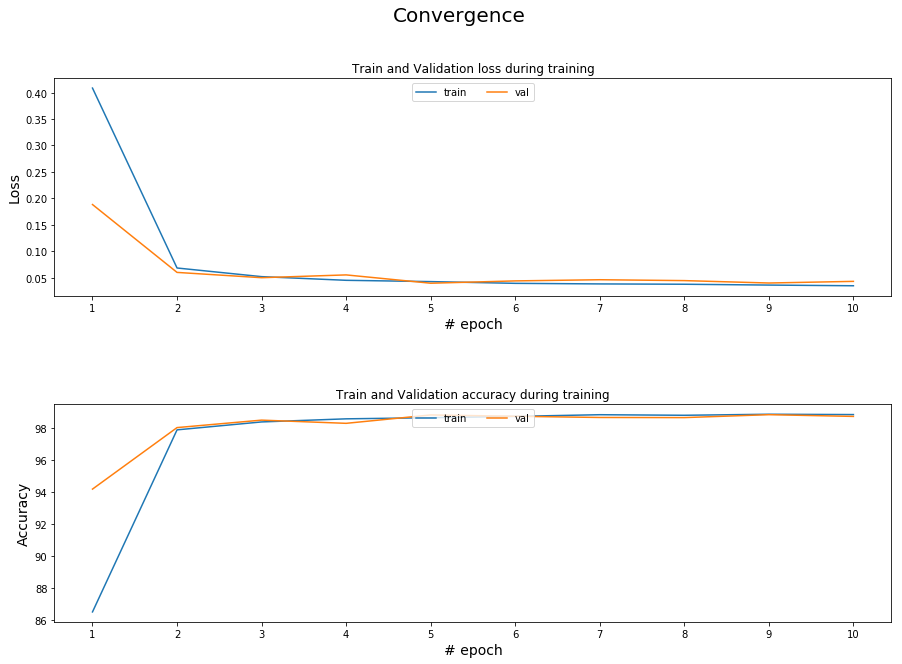

In [13]:
fig, axes = plt.subplots(2, 1)
for i, measure in enumerate(['loss', 'acc']):
    loss_figures = {'train':train_history['train_'+measure+'_hist'],
                    'val':train_history['val_'+measure+'_hist']}
    ax = axes[i]
    for loss_name, loss_history in list(loss_figures.items()):
        ax.plot(np.arange(1,11),loss_history, label = loss_name, rasterized=True)
        ax.set_xlabel('# epoch', size=14)
        ax.legend(loc='upper center', ncol=2)
        if measure == 'loss':
            ax.set_ylabel('Loss', size=14)
        else:
            ax.set_ylabel('Accuracy', size=14)
        ax.xaxis.set_ticks(np.linspace(1, len(loss_history), 10).astype(int))
        ax.xaxis.set_ticklabels(np.linspace(1, 10, 10).astype(int))

plt.gcf().set_size_inches(15, 10)
plt.subplots_adjust(hspace=0.5)
fig.suptitle('Convergence', size=20)
axes[0].title.set_text('Train and Validation loss during training')
axes[1].title.set_text('Train and Validation accuracy during training')
plt.show()

### 3. Visualizing Predictions for Validation Samples

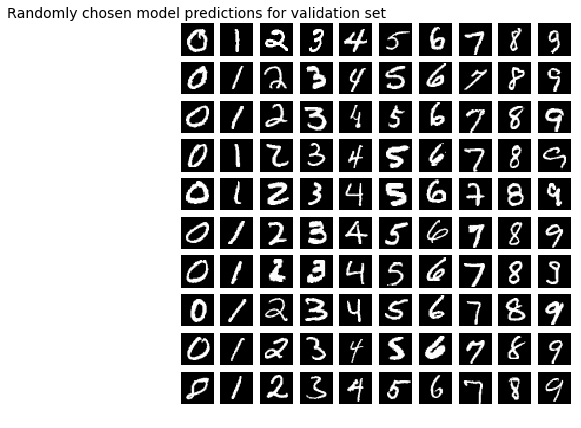

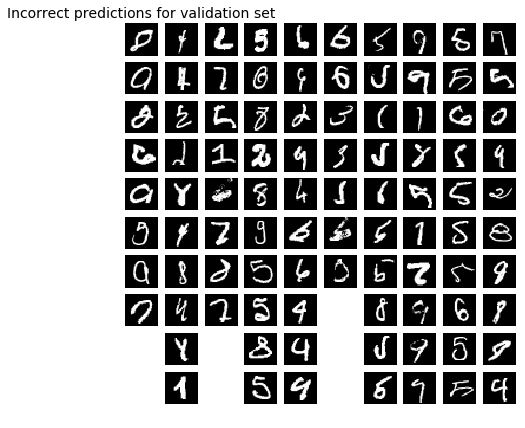

In [14]:
categorized_data = {0:[],1:[],2:[],3:[],4:[],5:[],6:[],7:[],8:[],9:[]}
misclassified_data = {0:[],1:[],2:[],3:[],4:[],5:[],6:[],7:[],8:[],9:[]}

category_lens = 0
model.eval()  # change model mode to eval
with torch.no_grad():  # temporarily set all requires_grad flags to False
    for X, y in loader_val:
        # Move inputs to specified device
        X = X.to(device=device, dtype=torch.float32)
        y = y.to(device=device, dtype=torch.long)

        # Compute scores (Forward pass)
        scores = model(X)
        _, preds = scores.max(dim=1)
        
        # Convert tensor to numpy array
        data = X.cpu().numpy()
        preds = preds.cpu().numpy()
        y = y.cpu().numpy()
        
        # Fill dictionary of predictions
        if np.min(category_lens)<10:
            for num, category in enumerate(preds):
                categorized_data[category].append([data[num]])
        
        # Fill dictionary of incorrect predictions
        for num, category in enumerate(preds):
            if category != y[num]:
                misclassified_data[category].append([data[num]])
        
        # Break out of loop when we have 10 samples per category
        category_lens = np.array([len(samples) for category,samples in categorized_data.items()])
        misclassified_lens = np.array([len(samples) for category,samples in misclassified_data.items()])
        if (np.min(category_lens)>10) and (np.min(misclassified_lens)>10):
            break

pltClasses(categorized_data, 'Randomly chosen model predictions for validation set')
pltClasses(misclassified_data, 'Incorrect predictions for validation set')